In [1]:
from relic.graphs.graphs import get_precision_recall #, draw_graph
import pandas as pd
import networkx as nx
import os
import glob

import numpy as np
import pickle
import seaborn as sns
import logging
from tqdm.notebook import tqdm

In [2]:
base_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing'



def process_directory(base_dir, score_type='groupby', sample_score_file="groupby_gt_scores.csv"):
    workflow_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    #all_gt_graphs = {}
    edges_df = pd.DataFrame()
    #relic_result_df = pd.DataFrame()
    #columns = ['nb_name', 'df1', 'df2', score_type, 'sampling', 'index']
    #columns = ['nb_name', 'edge', score_type, 'sampling', 'index']
    #columns = ['nb_name', 'src', 'dst', score_type, 'sampling', 'index']
    
    #print(workflow_ids)
    for i in tqdm(workflow_ids):
        #print(i)
        inferred_dir = f"{base_dir}/{i}/inferred/"
        try:
            # Load dfs for each sample type
            for sample_dir in glob.glob(inferred_dir+'/gbsample_*_*/'):
                sample_dir_name = os.path.basename(sample_dir[:-1])
                _, index, frac = sample_dir_name.split('_')
                try:
                    score_df = pd.read_csv(f"{sample_dir}/{sample_score_file}")
                    score_df['index'] = index
                    score_df['sampling'] = float(frac)
                    score_df['nb_name'] = i
                    edges_df = edges_df.append(score_df, ignore_index=True)
                    
                    
                except Exception as e:
                    logging.warning(f'{i}:{e}')
                    pass
            
        except FileNotFoundError as e:
            logging.warning(f'Could not load File: {e}')
            pass
            
    # Frozenset edges for easier computation
    #edges_df['edge'] = edges_df.apply(lambda x: frozenset([x.df1, x.df2]), axis=1)
    # Annotate GT information
    #edges_df['gt_operation'] = edges_df.apply(lambda x: is_gt_edge(x, all_gt_graphs), axis=1)
        
    return edges_df


In [3]:
edges_df = process_directory(base_dir)
edges_df

  0%|          | 0/200 [00:00<?, ?it/s]

2021-11-16 13:28:08,103 root WARNING:20210126-181148:[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/20210126-181148/inferred/gbsample_False_0.25//groupby_gt_scores.csv'
2021-11-16 13:28:08,115 root WARNING:20210126-181148:[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/20210126-181148/inferred/gbsample_False_0.10//groupby_gt_scores.csv'
2021-11-16 13:28:08,127 root WARNING:20210126-181148:[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/20210126-181148/inferred/gbsample_False_0.5//groupby_gt_scores.csv'
2021-11-16 13:28:08,139 root WARNING:20210126-181148:[Errno 2] No such file or directory: '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/20210126-181148/inferred/gbsample_False_0.75//groupby_gt_scores.csv'
2021-11-16 13:28:08,151 root WARNING:

,df1,df2,sample,index,sampling,nb_name
0,0.csv,2.csv,2.994796,False,0.75,20210126-161024
1,2.csv,0.csv,3.000000,False,0.50,20210126-161024
2,0.csv,2.csv,2.972378,False,0.05,20210126-161024
3,2.csv,0.csv,3.000000,False,0.25,20210126-161024
4,2.csv,0.csv,3.000000,False,0.10,20210126-161024
...,...,...,...,...,...,...
3548,11.csv,16.csv,2.000000,False,0.05,20210126-155237
3549,1.csv,0.csv,2.000000,False,0.50,20210126-155237
3550,11.csv,16.csv,2.000000,False,0.50,20210126-155237
3551,8.csv,7.csv,3.000000,False,0.50,20210126-155237


In [4]:
len(set(edges_df['nb_name'].values))

190

In [5]:
edges_df['edge'] = edges_df.apply(lambda x: frozenset([x['df1'], x['df2']]), axis=1) #.loc[edges_df.nb_name == '20210126-153738']

In [6]:

results = edges_df.pivot(index=['nb_name','edge'], columns='sampling', values='sample').dropna()#.reset_index()
results

sampling                          0.05  0.10  0.25  0.50  0.75  1.00
nb_name         edge                                                
20210126-153738 (15.csv, 13.csv)   1.0   0.0   1.0   1.0   1.0   1.0
20210126-153741 (5.csv, 3.csv)     1.0   1.0   1.0   1.0   1.0   1.0
20210126-153743 (0.csv, 3.csv)     1.0   1.0   1.0   1.0   1.0   1.0
20210126-153749 (11.csv, 17.csv)   2.0   2.0   2.0   2.0   2.0   2.0
20210126-153755 (2.csv, 3.csv)     0.0   0.0   0.0   0.0   1.0   1.0
...                                ...   ...   ...   ...   ...   ...
20210126-201524 (32.csv, 48.csv)   1.0   1.0   1.0   1.0   1.0   1.0
                (3.csv, 9.csv)     1.0   1.0   1.0   1.0   1.0   1.0
                (40.csv, 39.csv)   2.0   2.0   2.0   2.0   2.0   2.0
                (33.csv, 44.csv)   3.0   3.0   3.0   3.0   3.0   3.0
                (22.csv, 15.csv)   3.0   0.0   3.0   3.0   0.0   3.0

[540 rows x 6 columns]

In [7]:
results = results.loc[results[1.00] > 0].copy()
results

sampling                          0.05  0.10  0.25  0.50  0.75  1.00
nb_name         edge                                                
20210126-153738 (15.csv, 13.csv)   1.0   0.0   1.0   1.0   1.0   1.0
20210126-153741 (5.csv, 3.csv)     1.0   1.0   1.0   1.0   1.0   1.0
20210126-153743 (0.csv, 3.csv)     1.0   1.0   1.0   1.0   1.0   1.0
20210126-153749 (11.csv, 17.csv)   2.0   2.0   2.0   2.0   2.0   2.0
20210126-153755 (2.csv, 3.csv)     0.0   0.0   0.0   0.0   1.0   1.0
...                                ...   ...   ...   ...   ...   ...
20210126-201524 (32.csv, 48.csv)   1.0   1.0   1.0   1.0   1.0   1.0
                (3.csv, 9.csv)     1.0   1.0   1.0   1.0   1.0   1.0
                (40.csv, 39.csv)   2.0   2.0   2.0   2.0   2.0   2.0
                (33.csv, 44.csv)   3.0   3.0   3.0   3.0   3.0   3.0
                (22.csv, 15.csv)   3.0   0.0   3.0   3.0   0.0   3.0

[516 rows x 6 columns]

In [8]:
normalize_base_col = 1.0
if normalize_base_col:
    for col in results.columns:
        base_col = normalize_base_col
        if col != base_col:
            #results[col] = results[base_col]  - results[col]
            results[col] = (results[base_col] - results[col]) / results[base_col]
        else:
            results[col] = 0
            
results

sampling                          0.05  0.10  0.25  0.50  0.75  1.00
nb_name         edge                                                
20210126-153738 (15.csv, 13.csv)   0.0   1.0   0.0   0.0   0.0     0
20210126-153741 (5.csv, 3.csv)     0.0   0.0   0.0   0.0   0.0     0
20210126-153743 (0.csv, 3.csv)     0.0   0.0   0.0   0.0   0.0     0
20210126-153749 (11.csv, 17.csv)   0.0   0.0   0.0   0.0   0.0     0
20210126-153755 (2.csv, 3.csv)     1.0   1.0   1.0   1.0   0.0     0
...                                ...   ...   ...   ...   ...   ...
20210126-201524 (32.csv, 48.csv)   0.0   0.0   0.0   0.0   0.0     0
                (3.csv, 9.csv)     0.0   0.0   0.0   0.0   0.0     0
                (40.csv, 39.csv)   0.0   0.0   0.0   0.0   0.0     0
                (33.csv, 44.csv)   0.0   0.0   0.0   0.0   0.0     0
                (22.csv, 15.csv)   0.0   1.0   0.0   0.0   1.0     0

[516 rows x 6 columns]

<AxesSubplot:xlabel='sampling', ylabel='gt_operation'>

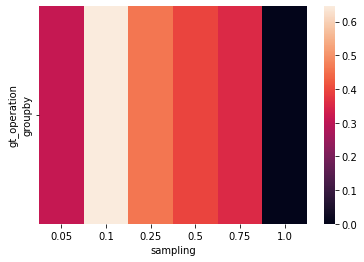

In [9]:
results['gt_operation'] = 'groupby'
gb_heatmap = results.groupby('gt_operation').mean().abs()
sns.heatmap(gb_heatmap)

In [10]:
# Variation Analysis for a given sampling ratio:
results.loc[(results[0.05] == 0) & (results[0.1] > 0)]

,sampling,0.05,0.1,0.25,0.5,0.75,1.0,gt_operation
nb_name,edge,,,,,,,
20210126-153738,"(15.csv, 13.csv)",0.0,1.000000,0.000000,0.000000,0.000000,0,groupby
20210126-153820,"(0.csv, 1.csv)",0.0,0.018219,0.064777,0.000000,0.002699,0,groupby
20210126-154011,"(4.csv, 3.csv)",0.0,0.023993,0.000000,0.000000,0.000000,0,groupby
20210126-154128,"(17.csv, 13.csv)",0.0,0.147795,0.000000,0.000000,0.000000,0,groupby
20210126-155348,"(17.csv, 0.csv)",0.0,0.453925,1.000000,0.549488,0.000000,0,groupby
20210126-155455,"(15.csv, 9.csv)",0.0,1.000000,0.000000,0.161290,0.000000,0,groupby
20210126-161736,"(2.csv, 9.csv)",0.0,1.000000,0.000000,0.000000,0.000000,0,groupby
20210126-163715,"(0.csv, 10.csv)",0.0,1.000000,0.000000,0.000000,0.000000,0,groupby
20210126-163943,"(11.csv, 3.csv)",0.0,0.006838,0.002867,0.000000,0.000000,0,groupby


In [66]:
from relic.approx.sampling import load_df_sample
from relic.distance.nppo import sample_groupby_detector

def simulate_sample_groupby_detector(file1, file2, data_dir, sample_frac=0.1, nsim=10):
    src = pd.read_csv(data_dir+file1, index_col=0)
    dst = pd.read_csv(data_dir+file2, index_col=0)
    df_dict = {file1: src, file2: dst}
    results = []
    for i in tqdm(range(nsim)):
        src_sample = load_df_sample(data_dir+file1, frac=sample_frac)
        dst_sample = load_df_sample(data_dir+file2, frac=sample_frac)
        sampled_df_dict = {file1: src_sample, file2: dst_sample}
        result_tuple = sample_groupby_detector(file1, file2, df_dict, sampled_df_dict, sample_frac)
        results.append(result_tuple)
    return results

In [67]:
wf_id = '20210126-170349'	
f1 = '1.csv'
f2 = '6.csv'
data_dir = f'/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact_sample_timing/{wf_id}/artifacts/'

variance_result = simulate_sample_groupby_detector(f1, f2, data_dir, sample_frac=0.05)
variance_result

  0%|          | 0/10 [00:00<?, ?it/s]

[(frozenset({'1.csv', '6.csv'}), {'groupby': 0.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 0.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 0.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0}),
 (frozenset({'1.csv', '6.csv'}), {'groupby': 3.0})]

In [16]:
[x[1] for x in variance_result]

[3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 3.0]

In [68]:
v_result_dict = {}
for samp in tqdm([0.05, 0.1, 0.25, 0.5, 0.75]):
    v_result = simulate_sample_groupby_detector(f1, f2, data_dir, sample_frac=samp)
    v_result_dict[samp] = [x[1]['groupby'] for x in v_result]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [55]:
v_result_dict

{0.05: [1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 0.1: [0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
 

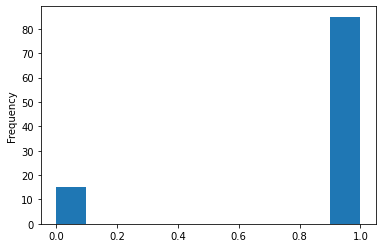

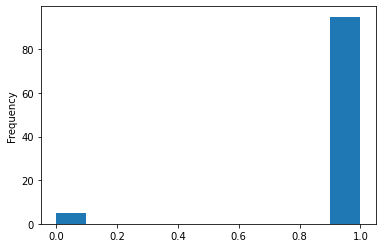

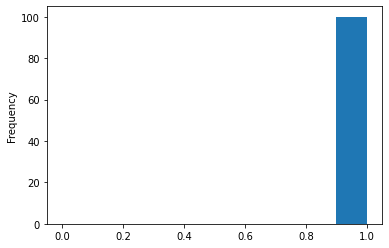

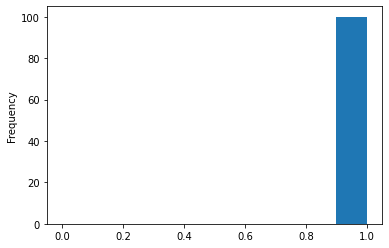

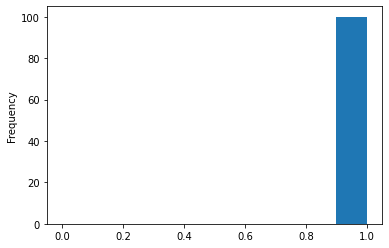

In [58]:
import matplotlib.pyplot as plt
for samp in [0.05, 0.1, 0.25, 0.5, 0.75]:
    plt.figure()
    pd.DataFrame(v_result_dict)[samp].plot.hist(bins=np.arange(0,1.1,0.1))

In [43]:
# Contaiment Estimation Mean and Variance
from relic.approx.containment import sample_col_containment

f1 = '1.csv'
f2 = '6.csv'
src =  pd.read_csv(data_dir+f1, index_col=0)
dst =  pd.read_csv(data_dir+f2, index_col=0)
sample_frac = 0.05
colname = 'state'
all_c_result = {}

for samp in tqdm([0.05, 0.1, 0.25, 0.5, 0.75]):
    samp_results = []
    for i in tqdm(range(100)):
        src_sample = load_df_sample(data_dir+f2, frac=samp)
        c_result = sample_col_containment(src, dst, src_sample, colname, sampling_ratio=samp)
        samp_results.append(c_result)
    all_c_result[samp] = samp_results

all_c_result

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

{0.05: [0.9523809523809523,
  0.47619047619047616,
  1.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  0.47619047619047616,
  1.0,
  0.9523809523809523,
  1.0,
  0.9523809523809523,
  0.9523809523809523,
  1.0,
  0.47619047619047616,
  0.47619047619047616,
  0.47619047619047616,
  1.0,
  0.47619047619047616,
  0.9523809523809523,
  0.0,
  0.47619047619047616,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.47619047619047616,
  0.9523809523809523,
  1.0,
  0.9523809523809523,
  0.9523809523809523,
  1.0,
  0.9523809523809523,
  0.0,
  1.0,
  0.47619047619047616,
  1.0,
  0.9523809523809523,
  1.0,
  1.0,
  0.9523809523809523,
  0.9523809523809523,
  0.9523809523809523,
  1.0,
  0.9523809523809523,
  0.9523809523809523,
  0.47619047619047616,
  0.47619047619047616,
  0.47619047619047616,
  0.47619047619047616,
  0.9523809523809523,
  1.0,
  1.0,
  0.9523809523809523,
  0.47619047619047616,
  0.47619047619047616,
  0.47619047619047616,
  1.0,
  0.47619047619047616

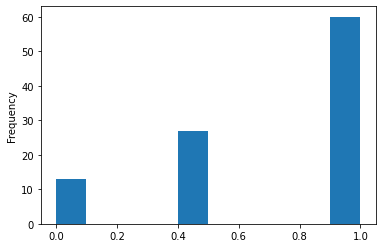

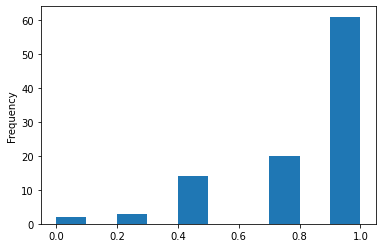

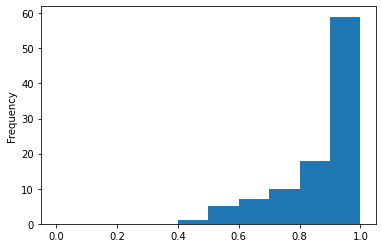

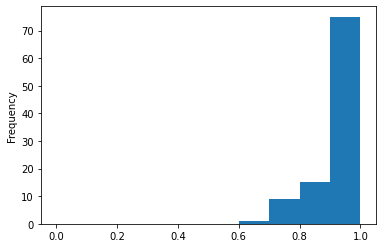

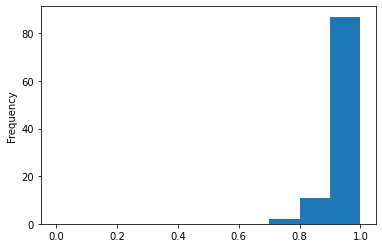

In [59]:
import matplotlib.pyplot as plt
for samp in [0.05, 0.1, 0.25, 0.5, 0.75]:
    plt.figure()
    pd.DataFrame(all_c_result)[samp].plot.hist(bins=np.arange(0,1.1,0.1))

In [62]:
src

,state,random_lowercase_letter,bothify,safari,month_name,paragraph,safe_email
94,Pennsylvania,m,53 Kn,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_0 r...,January,Beat its gas other positive peace. Even fine g...,santosgeoffrey@example.com
2,Iowa,o,75 bq,Mozilla/5.0 (Windows; U; Windows 98; Win 9x 4....,April,Write ok power quality exist provide organizat...,wadepaula@example.net
11,North Carolina,h,61 uX,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3 like M...,June,People you put president power. Structure beco...,rosariomartin@example.org
83,Oklahoma,b,66 ST,Mozilla/5.0 (Windows; U; Windows 95) AppleWebK...,March,Ask success box last. Former reach finally man...,mfitzpatrick@example.net
41,Massachusetts,l,36 fC,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_8_9...,August,Or answer successful seat us area resource. In...,julieflores@example.com
...,...,...,...,...,...,...,...
68,Hawaii,u,13 ow,Mozilla/5.0 (Windows; U; Windows 95) AppleWebK...,August,List risk six stay drug old stand trouble. Sho...,ccaldwell@example.org
30,Nebraska,m,06 Fh,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_10_...,September,Why before season investment surface their pro...,burkejames@example.net
5,Utah,d,43 ba,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_2 like M...,February,Officer call people dinner newspaper. Manageme...,connorclay@example.net
36,Mississippi,p,15 dJ,Mozilla/5.0 (iPod; U; CPU iPhone OS 4_3 like M...,July,Another technology performance people. Trip wo...,uvaldez@example.com


In [49]:
dst

,state,random_lowercase_letter,bothify,safari,month_name,paragraph,safe_email
0,Alabama,2,2,2,2,2,2
1,Alaska,2,2,2,2,2,2
2,Arizona,1,1,1,1,1,1
3,Arkansas,1,1,1,1,1,1
4,California,2,2,2,2,2,2
5,Connecticut,2,2,2,2,2,2
6,Delaware,5,5,5,5,5,5
7,Florida,1,1,1,1,1,1
8,Georgia,1,1,1,1,1,1
9,Hawaii,2,2,2,2,2,2


In [63]:
f1 = '1.csv'
f2 = '6.csv'
src =  pd.read_csv(data_dir+f1, index_col=0)
dst =  pd.read_csv(data_dir+f2, index_col=0)

In [64]:
src

,domain_word,boolean,suffix,company_suffix,prefix_male,mac_processor,domain_name,uri_path,md5
0,trevino-stewart,False,Jr.,LLC,Mr.,U; PPC,rollins.net,tag,4c2ee25da2ac5d898cda0acd24c4193a
1,long-braun,False,DDS,Group,Mr.,Intel,valencia-jackson.com,main,5618d2f4f83f20b0ea6a182a11e85135
2,mclean-cox,True,Jr.,Inc,Mr.,U; PPC,hudson.net,blog/app,5cf23f407e98747e148dd7b2184a8e35
3,pearson,True,Jr.,LLC,Mr.,U; Intel,rodriguez.com,blog/app,8746b3401ceafbd66507df6e51e8b3e1
4,delgado,True,II,LLC,Dr.,PPC,bailey-rhodes.com,app/posts,c746f331bb1220cdf88ee12952e956bf
...,...,...,...,...,...,...,...,...,...
99995,moore,True,MD,and Sons,Dr.,Intel,sparks.net,blog/categories/app,8dcbfd8a6e51edce00b359aaa895d2ee
99996,ashley,False,DDS,LLC,Mr.,U; PPC,garcia.com,tag,a00c014bd6b77b4b61b068772652f917
99997,allen-martin,True,III,LLC,Mr.,Intel,brown.com,categories/main/app,3f0a6704f0b8d72546a99a4c1b01f13e
99998,wheeler,False,MD,LLC,Mr.,U; PPC,bruce.com,category/tags,f3d3e5dcadcfc773dd4314dbf2b554e0


In [65]:
dst

,prefix_male,domain_word,boolean,suffix,company_suffix,mac_processor,domain_name,uri_path,md5
0,Dr.,zuniga-wagner,True,V,and Sons,U; PPC,zuniga.com,wp-content/wp-content/wp-content,fffd6bedae61297766917dca11b6a1a0
1,Mr.,zuniga-wood,True,V,and Sons,U; PPC,zuniga.org,wp-content/wp-content/wp-content,ffffd2d39466aa896b89962a4b59ee17
